In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm

from datetime import datetime
from matplotlib import pyplot as plt

from statsforecast.models import AutoARIMA

from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [5]:
def plot_ts_acf(df, x, y, n_lags=range(1,26)):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    sns.lineplot(df, x=x, y=y, color='k', marker='o', ax=ax0)
    plot_acf(df[y].dropna(), lags=n_lags, ax=ax1)
    plot_pacf(df[y].dropna(), lags=n_lags, ax=ax2)

    ax0.set_title('Seasonal Difference')

    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

def plot_ts_resid(df, x, y, n_lags=range(1,10), title=''):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    ax0.plot(df[y], marker='o', color='k',)
    #ax0.hlines(0, 2000, df['Resid'].shape[0], color='k', linestyle='--')

    plot_acf(df[y], ax=ax1, lags=n_lags)

    ax2.hist(df[y], bins=len(df) // 4)

    ax0.set_title(title)
    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

### 1.0. AR(p)

O modelo Arima é dividido em três partes, AR(p) e MA(q) que unidas geram o modelo ARMA(p, q) e o I vem do "Integrated" para levar em conta a diferenciação, ou seja ARIMA(p, d, q).

O componente AR(p) significa auto regressão com $p$ valores lag da variável $y_t$, a fórmula é: $y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + \dots + \phi_py_{t-p} + e_t$, o termo "auto" diz respeito que a regressão é com o próprio valor de $y$, por isso auto, e regressão pois é uma regressão com valores atrasados.

Existem algumas propriedades como:

- Se phi = 0, é equivalente a White Noise.
- Se phi = 1, é equivalente a Random Walk.
- Precisamos de |$\phi$| < 1, caso $\phi$ < 0, então tendemos a oscilar entre positivos e negativos.

Já o c é a "média" de $y_t$ o livro detalha esses cálculos.

In [6]:
et = np.array([np.random.normal() for i in range(1, 101)])
yt = np.array([np.random.normal() for i in range(1, 101)])

yt = np.abs(yt * 10)

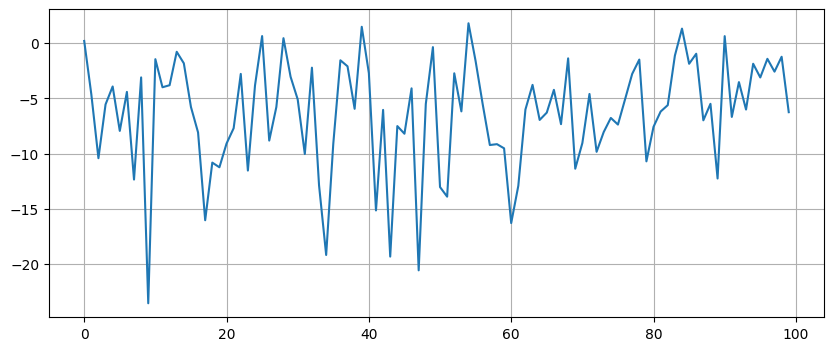

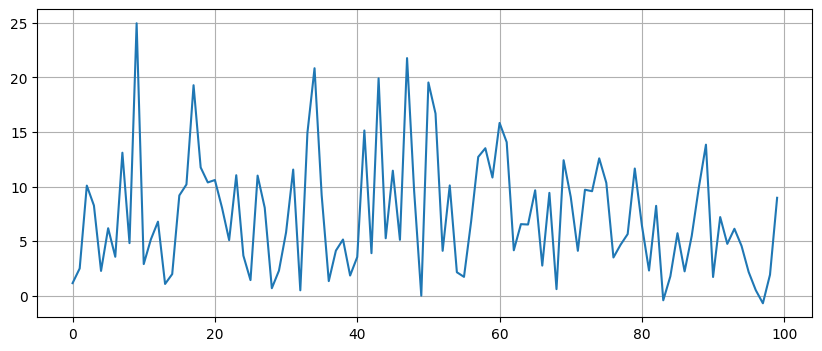

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(-0.8 * yt + et)
ax.grid(2)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(0.9 * yt + et)
ax.grid(2)

### 2.0. MA(q)

Primeiro de tudo, não devemos confundir com a média móvel para estimar a tendência apresentada no capítulo 3.
O termo MA(q) diz respeito a múltiplas regressões utilizando os erros passados (lags dos erros) como preditoras. E a fórmula é essa:

$y_t = c + e_t + \theta_1 e_{t-1} + \theta_2 e_{t-2} + \dots + \theta_q e_{t-q}$

### 3.0. Non Seasonal Arima

ARIMA(p, d, q)

- AR(p): Autoregressive Lagged Observations as Input.
- I(d): Integrated differencing for make serie Stationary.
- MA(q): Autoregressive Lagged Erros as Input.

$y_t = c + e_t + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \theta_{1} e_{t-1} + \dots + \theta_{q} e_{t-q}$

Modelos derivados do Arima:

1. White Noise: ARIMA(0, 0, 0), $y_t = e_t$.
2. Random Walk: ARIMA(0, 1, 0), $y_t = y_{t-1} + e_t$.
3. Random Walk with Drift: ARIMA(0, 1, 0) + c.
4. AR(p): ARIMA(P, 0, 0).
5. MA(q): ARIMA(0, 0, q).

Usando a notação backshift que reduz a quantidade de termos que temos que escrever, podemos representar um dos vários modelos arima da seguinte forma:

ARIMA(1, 1, 1) = $(1 - \phi_{1} B) \times (1 - B) \times y_t = c + (1 + \theta_1 B) \times e_t$.

Utilizando o AutoARIMA para a seleção automática de parâmetros a ideia é sempre reduzir o AICc ou AIC.

Por fim, para o cálculo de intervalos de confiança existem alguns bullet points, são eles:

- Os resíduos são normalmente distribuídos e não são correlacionados.
- O intervalo aumenta ao longo do nível.

#### 3.1. Global Economy EGY

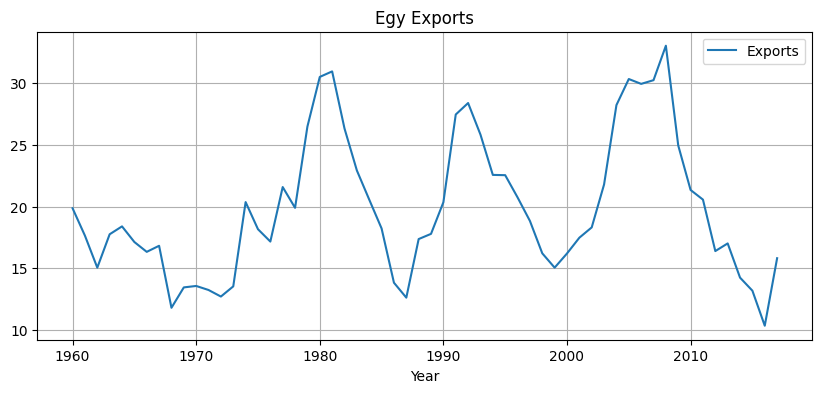

In [4]:
df = pd.read_csv('../data/global_economy.csv', index_col=[0])

df = df[df['Code'] == 'EGY'].reset_index(drop=2)

df.plot(
    x='Year',
    y='Exports',
    grid=2,
    title='Egy Exports',
    figsize=(10,4)
);

Podemos usar os gráficos ACF e PACF para selecionar modelos ARMA e ARIMA, entretanto o livro cita que não devemos fazer dessa forma e utilizar o modelo automático.

/tmp/ipykernel_4675/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


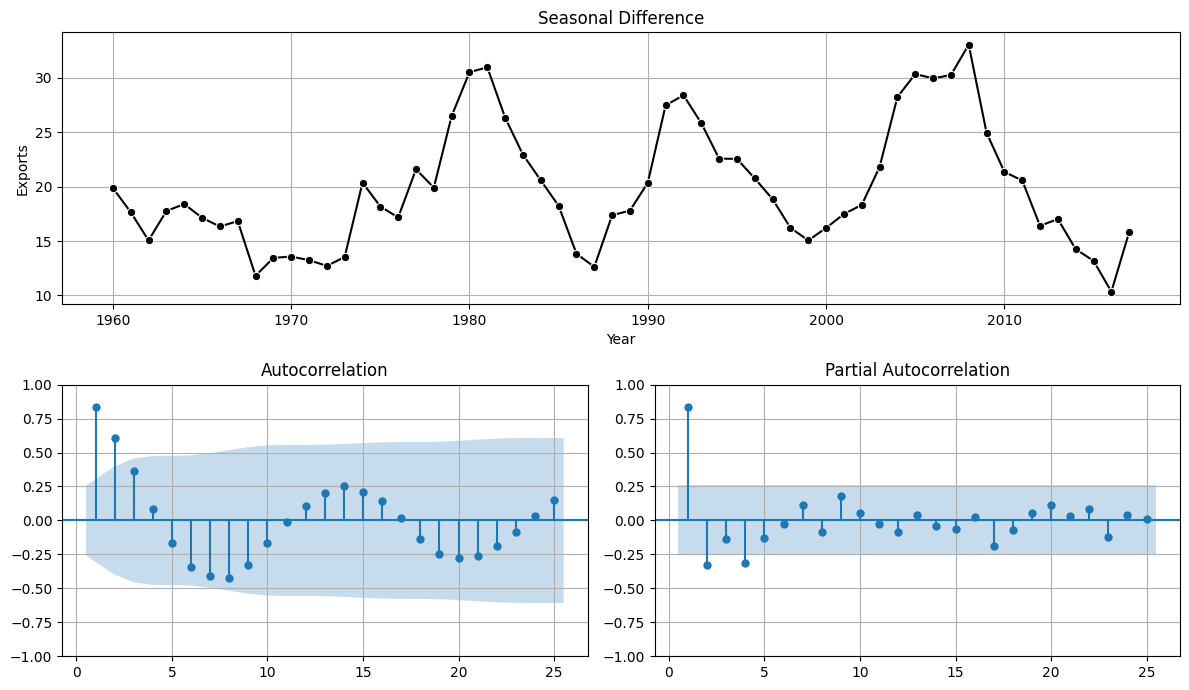

In [7]:
# Ar(2)
# I(0)
# Ma(1)

plot_ts_acf(df, x='Year', y='Exports')

In [8]:
auto = pm.auto_arima(
    df['Exports'],
    
    # Remove Cyclic Components for ARIMA model not SARIMA.
    start_Q=0,
    start_P=0,
    max_P=0,
    max_D=0,
    max_Q=0,
    max_order=0,
    seasonal=False
)

auto

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [21]:
auto.aicc()

294.2860818753551

In [16]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -141.566
Date:                Wed, 20 Dec 2023   AIC                            293.132
Time:                        19:13:50   BIC                            303.434
Sample:                             0   HQIC                           297.145
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5615      1.041      2.462      0.014       0.522       4.601
ar.L1          1.6765      0.127     13.242      0.000       1.428       1.925
ar.L2         -0.8034      0.102     -7.906      0.000      -1.003      -0.604
ma.L1         -0.6897      0.193     -3.574      0.000      -1.068      -0.312
sigma2         7.4910      1.546      4.844      0.000       4.460      10.522
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.86   Prob(JB):                         0.51
Heteroskedasticity (H):               1.00   Skew:                             0.35
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
auto.params()

intercept    2.561527
ar.L1        1.676499
ar.L2       -0.803439
ma.L1       -0.689736
sigma2       7.490973
dtype: float64

In [12]:
sauto = AutoARIMA(
    # Remove Cyclic Components for ARIMA model not SARIMA.
    start_Q=0,
    start_P=0,
    max_P=0,
    max_D=0,
    max_Q=0,
    max_order=0,
    seasonal=False,
    test="kpss",
    ic="aicc"
)

sauto.fit(df["Exports"].to_numpy())

AutoARIMA

In [23]:
sauto.model_

{'coef': {'ar1': 1.1844403086652253, 'ar2': -0.19992023254490954},
 'sigma2': 10.159843344612357,
 'var_coef': array([[ 2.29858536e-05, -1.90639490e-05],
        [-9.10517846e-05,  8.07039150e-05]]),
 'mask': array([ True,  True]),
 'loglik': -149.86578168969544,
 'aic': 305.7315633793909,
 'arma': (2, 0, 0, 0, 1, 0, 0),
 'residuals': array([ 3.11655996e+00, -1.92395575e+00, -1.87696346e+00,  3.45806559e+00,
         3.73015116e-01, -1.11015666e+00, -2.78984335e-01,  9.04687010e-01,
        -4.86384486e+00,  2.84034411e+00, -6.81711169e-03, -1.39550581e-01,
        -2.61201208e-01,  1.12791554e+00,  6.87686538e+00, -3.25008938e+00,
        -2.79667230e-01,  4.88460958e+00, -2.23222180e+00,  7.23412535e+00,
         3.11461754e+00,  1.15103168e-01, -4.23820566e+00, -2.06804276e+00,
        -1.32780250e+00, -1.54828745e+00, -3.64853086e+00, -1.17397082e-01,
         5.18621981e+00, -2.58409122e-01,  2.75373837e+00,  6.91451778e+00,
        -6.64327848e-02, -2.30558690e+00, -2.35459832e+0

In [27]:
fs, ints = auto.predict(10, return_conf_int=True)

forecast = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': fs.tolist(),
     'lower': ints[:, 0],
     'upper': ints[:, 1]}
)

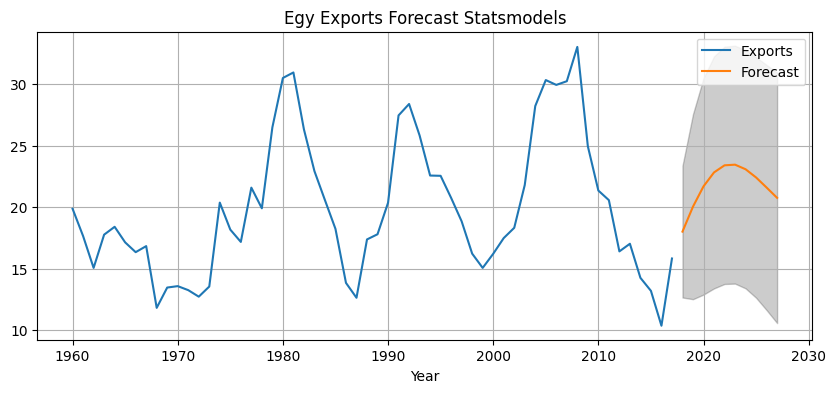

In [29]:
ax = df.plot(
    x='Year',
    y='Exports',
    title='Egy Exports Forecast Statsmodels',
    figsize=(10,4)
)
forecast.plot(
    x='Year', 
    y='Forecast', 
    ax=ax,
    grid=2
)
ax.fill_between(forecast['Year'], forecast['lower'], forecast['upper'], color='k', alpha=0.2);

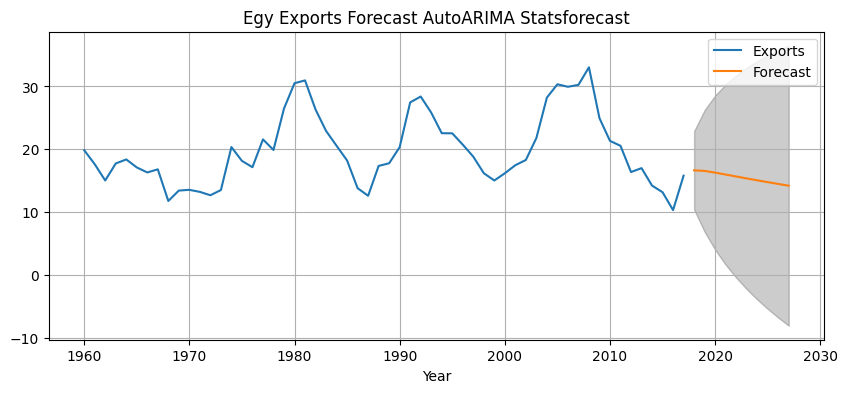

In [44]:
f = sauto.predict(10, level=[95])

forecast = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': f["mean"],
     'lower': f['lo-95'],
     'upper': f['hi-95']}
)

ax = df.plot(
    x='Year',
    y='Exports',
    title='Egy Exports Forecast AutoARIMA Statsforecast',
    figsize=(10,4)
)
forecast.plot(
    x='Year', 
    y='Forecast', 
    ax=ax,
    grid=2
)
ax.fill_between(forecast['Year'], forecast['lower'], forecast['upper'], color='k', alpha=0.2);

##### 3.1.1. Observação 1. ACF e PACF para selecionar p e q.

Para selecionar modelos AR(p) usando o gráfico ACF e PACF seguimos algumas regras:

1. O Acf decai exponencialmente.
2. Existe um $p$ significativo no gráfico PACF.

Para selecionar modelos MA(q) usamos também o gráfico de ACF e PACF e tem mais duas regras:

1. O PACF decai exponencialmente.
2. Existe um $q$ significante no gráfico ACF.

Entretanto alguns autores dizem que podemos misturar os dois modelos mas é meio estranho esse pensamento pois os gráficos são diferentes.

Em resumo, seria um ARIMA(4, 0, 0), quatro pois existe até 4 lags significativas no PACF, mas a ordem q poderia ser 1 pois declina exponencialmente até 2.

/tmp/ipykernel_4675/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


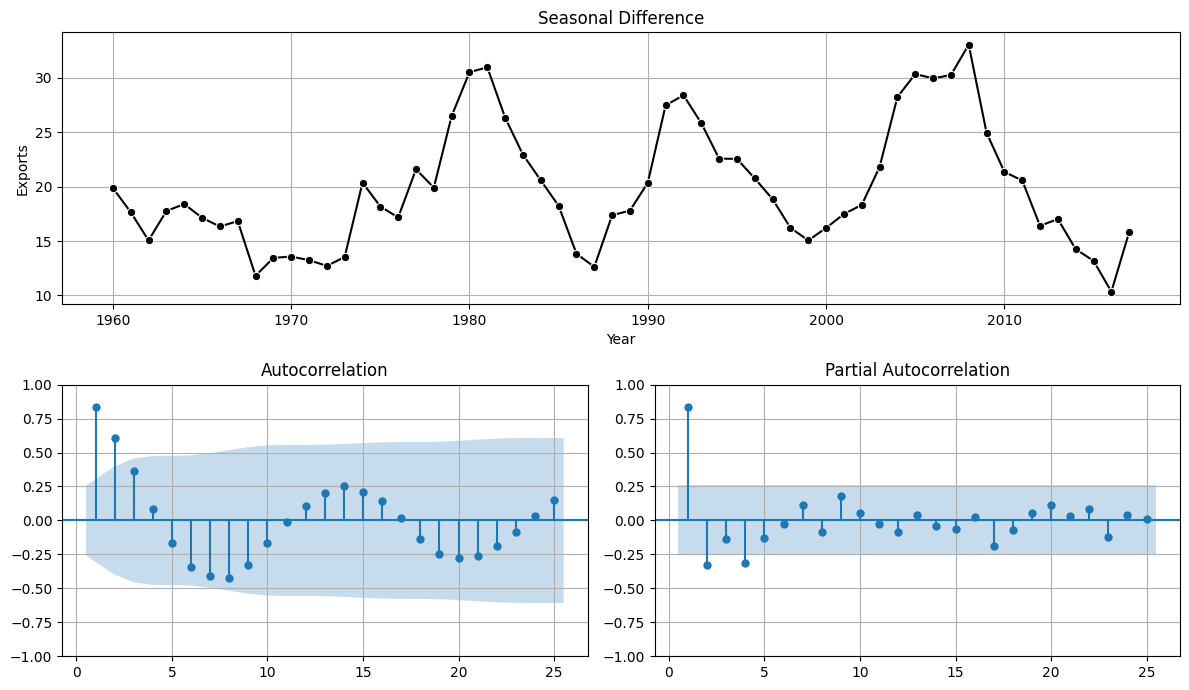

In [61]:
plot_ts_acf(df, x='Year', y='Exports')

In [64]:
a = pm.ARIMA(
    order=(4, 0, 0),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Exports"])

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(4, 0, 1)   Log Likelihood                -140.038
Date:                Wed, 20 Dec 2023   AIC                            294.076
Time:                        19:47:09   BIC                            308.499
Sample:                             0   HQIC                           299.694
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.3506      2.086      2.565      0.010       1.262       9.439
ar.L1          1.2550      0.345      3.634      0.000       0.578       1.932
ar.L2         -0.4525      0.425     -1.064      0.287      -1.286       0.381
ar.L3          0.2213      0.255      0.867      0.386      -0.279       0.722
ar.L4         -0.2895      0.166     -1.747      0.081      -0.614       0.035
ma.L1         -0.3090      0.353     -0.876      0.381      -1.000       0.382
sigma2         7.0776      1.488      4.756      0.000       4.161       9.995
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.95   Prob(JB):                         0.60
Heteroskedasticity (H):               1.06   Skew:                             0.31
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

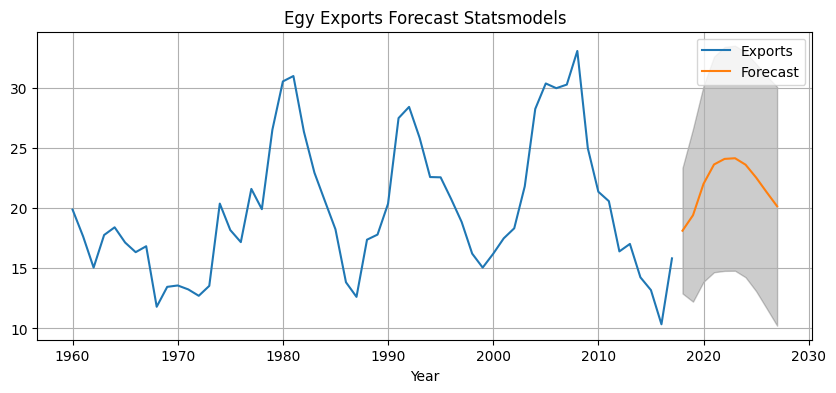

In [65]:
fs, ints = a.predict(10, return_conf_int=True)

forecast = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': fs.tolist(),
     'lower': ints[:, 0],
     'upper': ints[:, 1]}
)

ax = df.plot(
    x='Year',
    y='Exports',
    title='Egy Exports Forecast Statsmodels',
    figsize=(10,4)
)
forecast.plot( 
    x='Year', 
    y='Forecast', 
    ax=ax,
    grid=2
)
ax.fill_between(forecast['Year'], forecast['lower'], forecast['upper'], color='k', alpha=0.2);

##### 3.1.2. Observação 2. Quanto maior o nível da diferenciação, maior o intervalo de confiânça.

In [49]:
auto = pm.auto_arima(
    df['Exports'],
    
    d=2,

    # Remove Cyclic Components for ARIMA model not SARIMA.
    start_Q=0,
    start_P=0,
    max_P=0,
    max_D=0,
    max_Q=0,
    max_order=0,
    seasonal=False
)

auto

ARIMA(order=(2, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

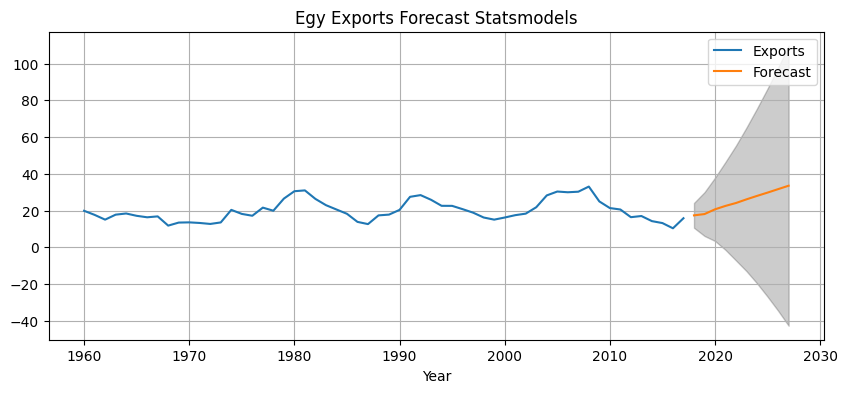

In [50]:
fs, ints = auto.predict(10, return_conf_int=True)

forecast = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': fs.tolist(),
     'lower': ints[:, 0],
     'upper': ints[:, 1]}
)

ax = df.plot(
    x='Year',
    y='Exports',
    title='Egy Exports Forecast Statsmodels',
    figsize=(10,4)
)
forecast.plot( 
    x='Year', 
    y='Forecast', 
    ax=ax,
    grid=2
)
ax.fill_between(forecast['Year'], forecast['lower'], forecast['upper'], color='k', alpha=0.2);

#### 3.2. Global Economy CAF

O gráfico abaixo possui tendência, logo ele não é estacionário, portanto para fitar no Arima é necessário uma diferenciação. 

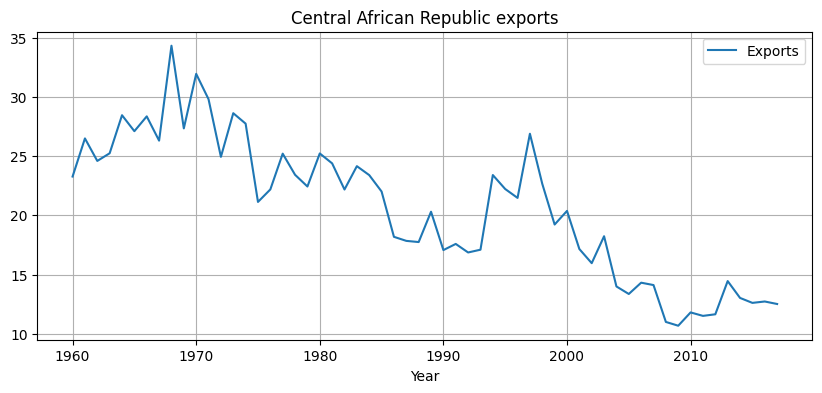

In [66]:
df = pd.read_csv('../data/global_economy.csv', index_col=[0])

df = df[df['Code'] == 'CAF'].reset_index(drop=2)

df.plot(
    x='Year',
    y='Exports',
    figsize=(10,4),
    title='Central African Republic exports',
    grid=2
);

Olhando os gráficos de ACF e PACF para a série original e a série diferenciada já podemos ter uma noção de qual Arima selecionar.

Como a série está diferenciada irei levar em conta os seguintes componentes para o Arima levando em conta a intuição e os gráficos: Arima(p, d, q) -> Arima(2, 1, 1), dois para o componente autoregressivo dos valores lagados, 1 para a autoregressao dos resíduos e 1 para a diferenciação.

No Livro, é citado 2 modelos sem levar em conta a diferenciação, são eles:

1. ARIMA(0, 1, 3) (Treinado logo abaixo).
2. ARIMA(2, 1, 0).

Mas, todos levando em conta a decomposição!

/tmp/ipykernel_4675/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
/tmp/ipykernel_4675/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


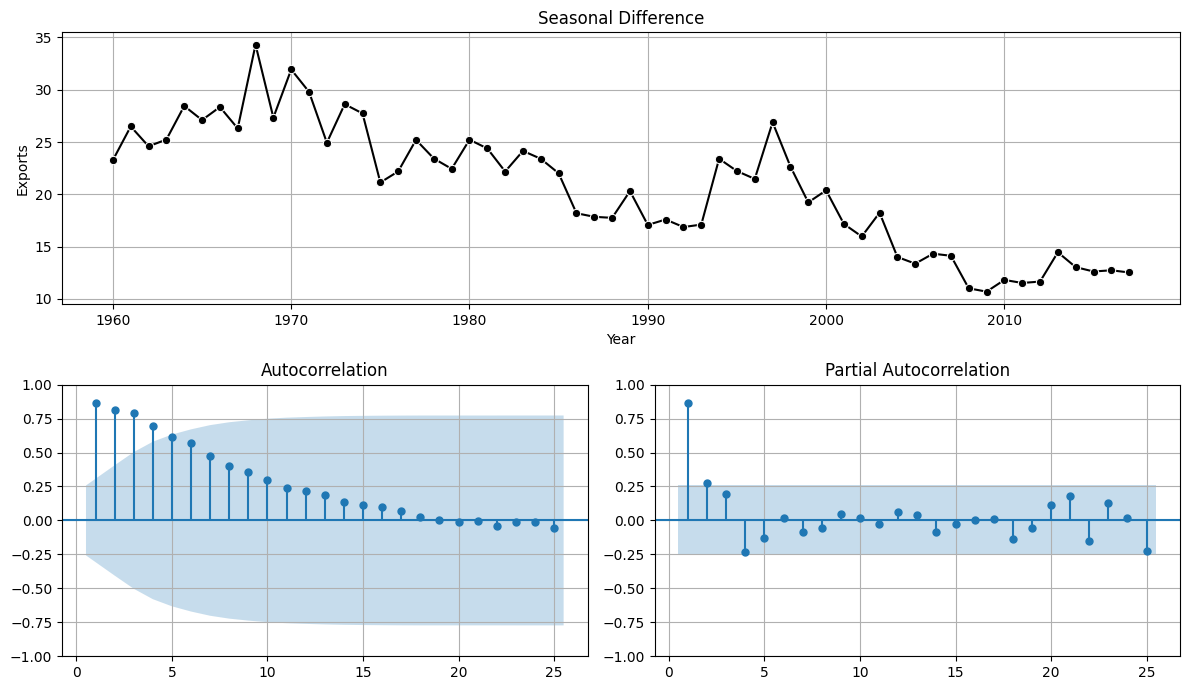

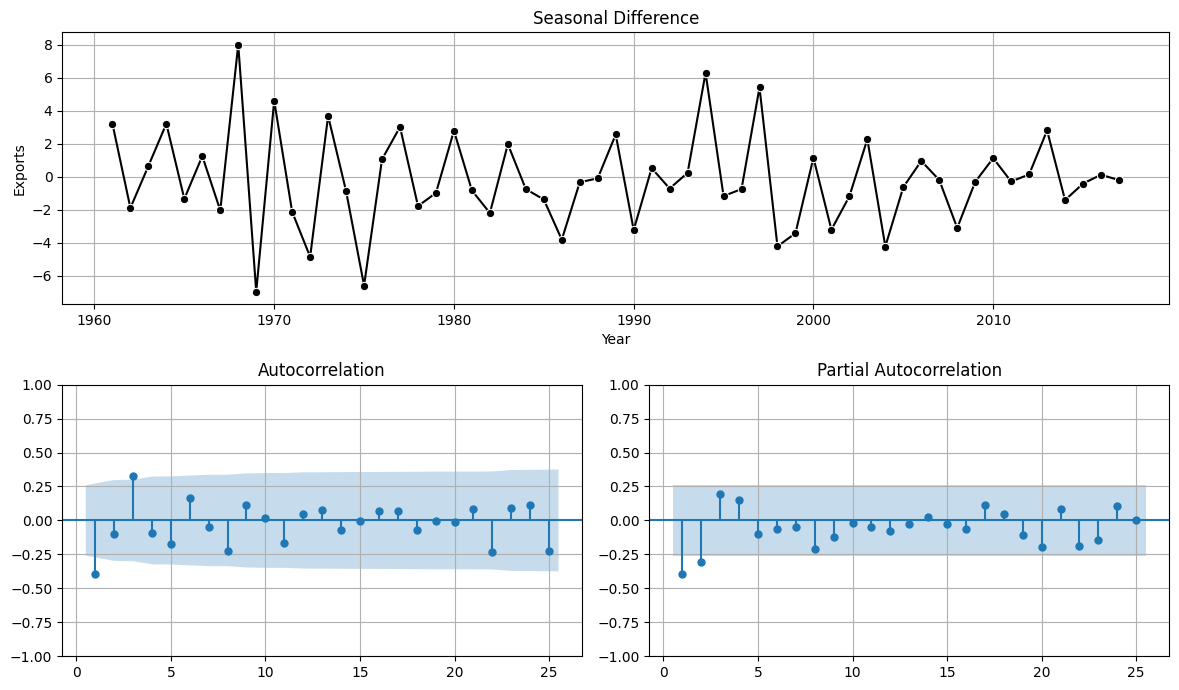

In [70]:
# Ar(2) - PACF
# D(1)  - Becuse Trend
# Ma(1) - ACF
 
aux = df.copy()
aux['Exports'] = df['Exports'].diff(1)

plot_ts_acf(df, x='Year', y='Exports')
plot_ts_acf(aux, x='Year', y='Exports')

O Autoarima selecionou Arima(2, 1, 2). Mas o AIC não mudou muito, irei chegar na previsão.

In [71]:
auto = pm.auto_arima(
    df['Exports'],

    # Remove seasonal Components for ARIMA model not SARIMA.
    start_Q=0,
    start_P=0,
    max_P=0,
    max_D=0,
    max_Q=0,
    max_order=0,
    seasonal=False
)

auto

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [72]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -132.098
Date:                Wed, 20 Dec 2023   AIC                            274.197
Time:                        20:41:34   BIC                            284.412
Sample:                             0   HQIC                           278.167
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6740      0.202     -3.329      0.001      -1.071      -0.277
ar.L2         -0.7141      0.196     -3.637      0.000      -1.099      -0.329
ma.L1          0.2468      0.216      1.141      0.254      -0.177       0.671
ma.L2          0.4831      0.315      1.531      0.126      -0.135       1.101
sigma2         5.9653      0.994      6.003      0.000       4.018       7.913
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 6.72
Prob(Q):                              0.73   Prob(JB):                         0.03
Heteroskedasticity (H):               0.35   Skew:                             0.63
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
a = pm.ARIMA(
    order=(2, 1, 1),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Exports"])

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -133.142
Date:                Wed, 20 Dec 2023   AIC                            276.285
Time:                        20:42:35   BIC                            286.500
Sample:                             0   HQIC                           280.255
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4584      0.498     -0.921      0.357      -1.434       0.517
ar.L1         -0.7624      0.383     -1.988      0.047      -1.514      -0.011
ar.L2         -0.4133      0.166     -2.491      0.013      -0.738      -0.088
ma.L1          0.2645      0.396      0.668      0.504      -0.511       1.040
sigma2         6.2125      1.065      5.832      0.000       4.125       8.300
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 5.54
Prob(Q):                              0.86   Prob(JB):                         0.06
Heteroskedasticity (H):               0.36   Skew:                             0.60
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
fs, ints = auto.predict(10, return_conf_int=True)

forecast = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': fs.tolist(),
     'lower': ints[:, 0],
     'upper': ints[:, 1]}
)

fs, ints = a.predict(10, return_conf_int=True)

forecasta = pd.DataFrame(
    {'Year': list(range(df['Year'].max() + 1, df['Year'].max() + 11, 1)),
     'Forecast': fs.tolist(),
     'lower': ints[:, 0],
     'upper': ints[:, 1]}
)

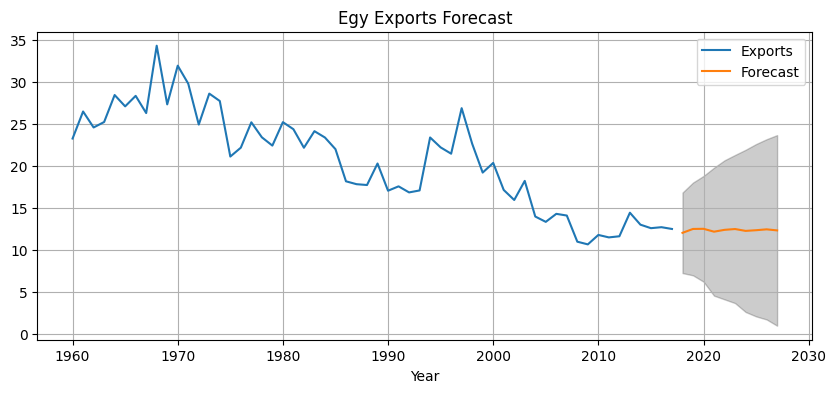

In [75]:
ax = df.plot(
    x='Year',
    y='Exports',
    title='Egy Exports Forecast',
    figsize=(10,4)
)
forecast.plot(
    x='Year', 
    y='Forecast', 
    ax=ax,
    grid=2
)
ax.fill_between(forecast['Year'], forecast['lower'], forecast['upper'], color='k', alpha=0.2);

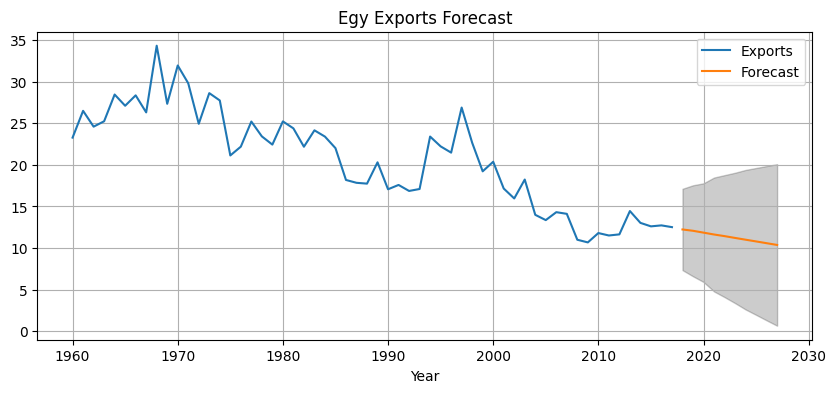

In [76]:
ax = df.plot(x='Year',y='Exports',title='Egy Exports Forecast',figsize=(10,4))
forecasta.plot(x='Year', y='Forecast', ax=ax, grid=2)
ax.fill_between(forecasta['Year'], forecasta['lower'], forecasta['upper'], color='k', alpha=0.2);

/tmp/ipykernel_4675/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


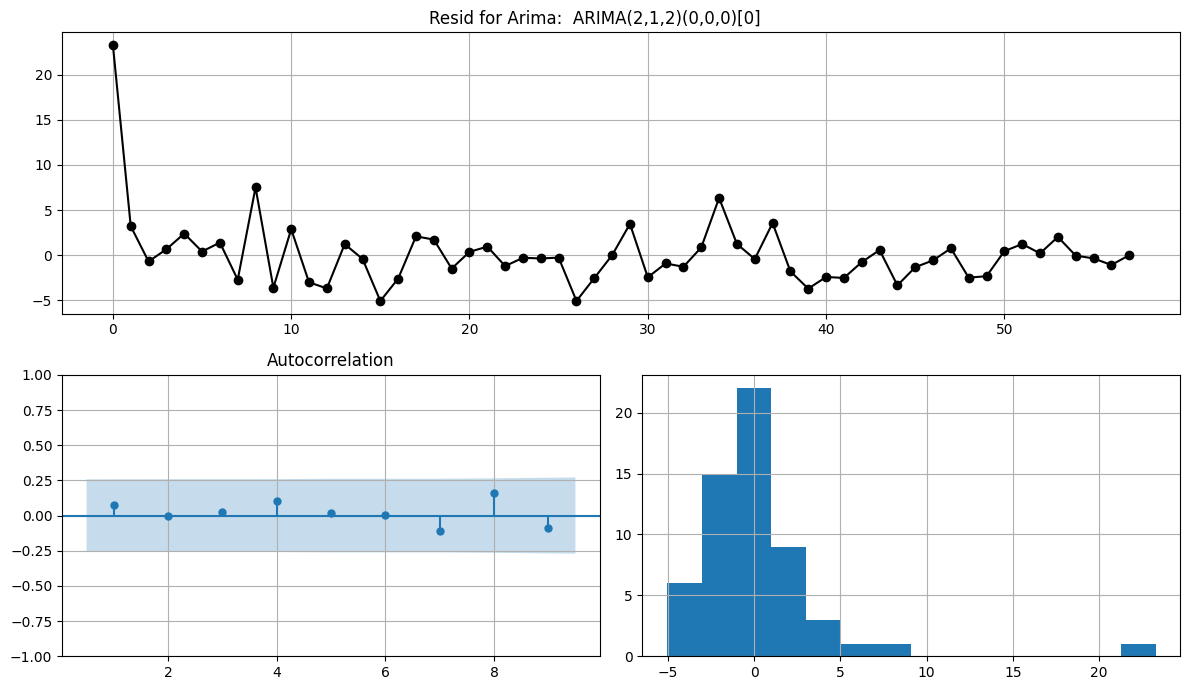

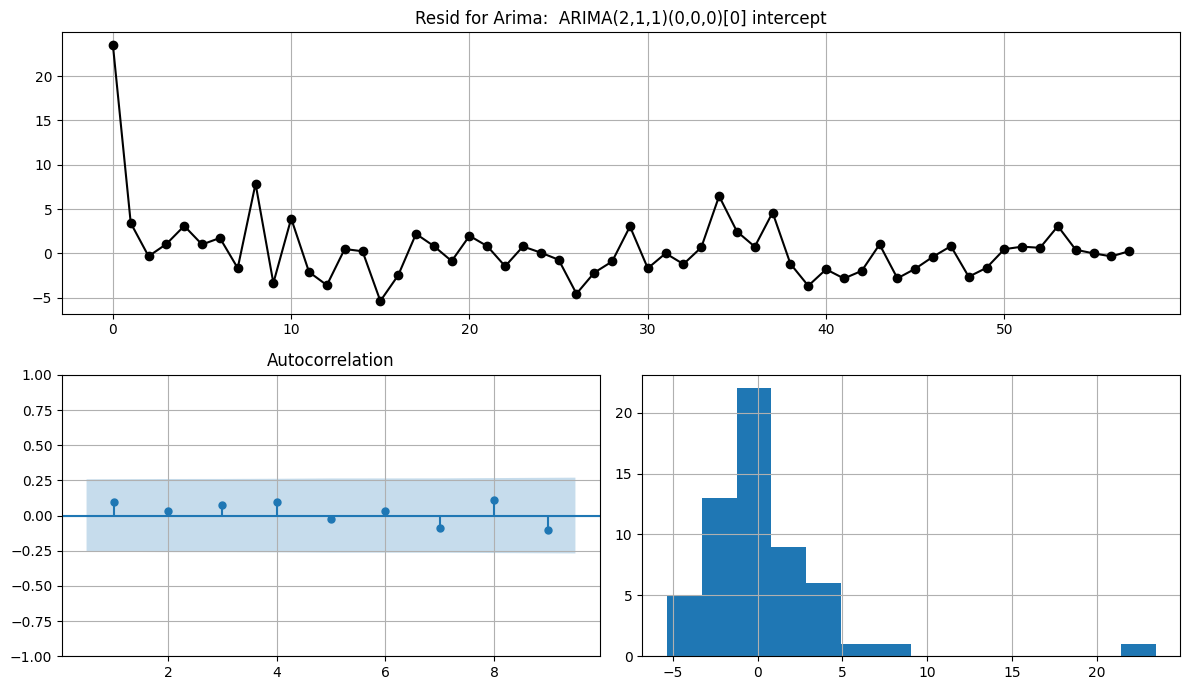

In [78]:
df['resid'] = auto.resid()

plot_ts_resid(df, x='Year', y='resid', title=f'Resid for Arima: {auto}')

df['resid'] = a.resid()

plot_ts_resid(df, x='Year', y='resid', title=f'Resid for Arima: {a}')

In [79]:
arima013 = pm.ARIMA(
    order=(0, 1, 3)
).fit(df['Exports'])

/tmp/ipykernel_4675/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


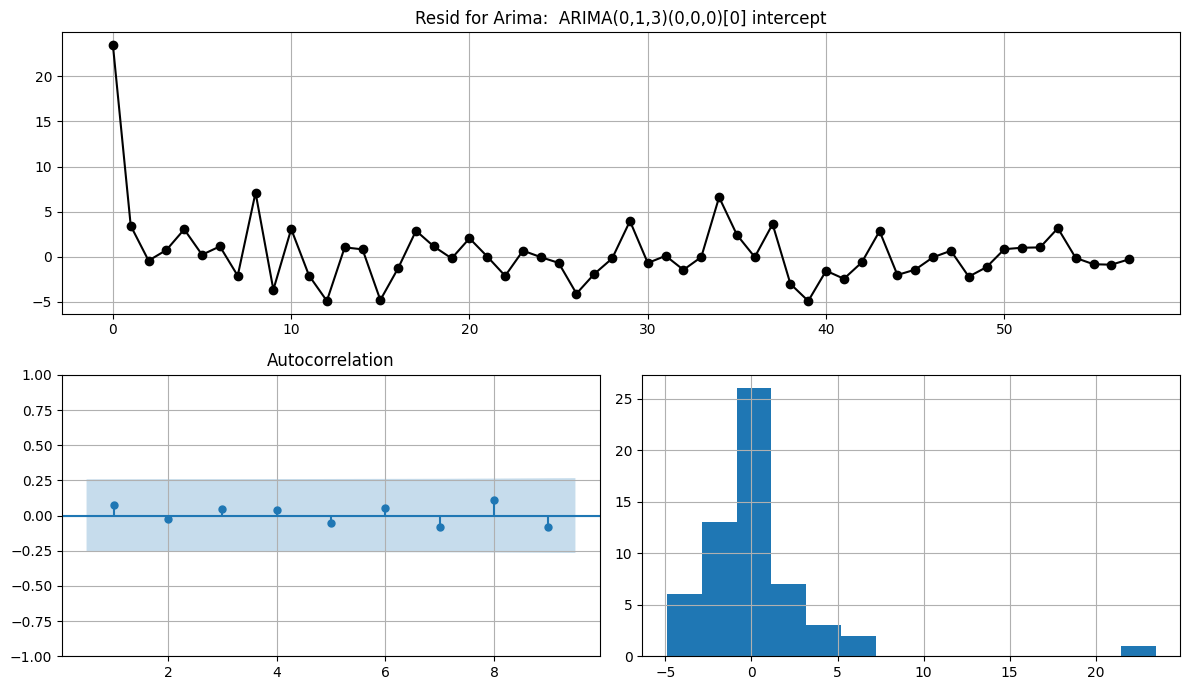

In [81]:
df['resid'] = arima013.resid()

plot_ts_resid(df, x='Year', y='resid', title=f'Resid for Arima: {arima013}')

### 4.0. Seasonal Arima

Em resumo, o modelo Sarima (Seasonal Arima) extende o modelo arima adicionando componentes da sazonalidade em letras maíusculas, são eles: (P, D, Q, m), onde m é o número de observações por ano ou numero de linhas por periodo.

No livro é citado o exemplo do modelo Arima(1, 1, 1)(1, 1, 1)4.

Fórmula: $(1 - \phi_1 B)(1 - \phi_1 B⁴)(1-B)(1-B^4)y_t = (1 + \theta_1 B) (1 + \theta_1 B⁴)e_t$

- Não Sazonal AR(1): $(1 - \phi_1 B)$.
- Sazonal AR(1): $(1 - \phi_1 B⁴)$.
- Não Sazonal Difference: $(1 - B)$.
- Sazonal Difference: $(1-B⁴)$.
- Não Sazonal MA(1): $(1 + \theta_1 B)$.
- Sazonal MA(1): $(1 + \theta_1 B⁴)$.

Similarmente ao Arima tradicional, podemos utilizar o ACF e PACF para indentificar os modelos SARIMA, tanto os componentes (p, d, q) e os componentes (P, D, Q, m).

A parte sazonal do SARIMA pode ser indentificada no ACF e PACF nos lags sazonais, exemplo dados mensais vai ter algum ponto nos gráficos que é significativo próximo aos lags 11, **12**, e 13.

Por exemplo, para um modelo SARIMA(0, 0, 0)(0, 0, 1, 12), m = 12 pois os dados são mensais, iremos conseguir observar:

1. Um ponto significativo no lag 12 do ACF mas nenhum outro ponto significativo.
2. Decaimento exponencial nos lags sazonais do PACF (12, 24, ...).

Similarmente, para um modelo SARIMA(0, 0, 0)(1, 0, 0, 12), m = 12 pois os dados são mensais, iremos conseguir observar:

1. Decaimento exponencial nos lags sazonais do ACF (12, 24, ...).
2. Um ponto significativo no lag 12 do PACF mas nenhum outro ponto significativo.

#### 4.1. Us Employment Dataset

In [4]:
df = pd.read_csv('../data/us_employment.csv', index_col=[0])
df['Month'] = pd.to_datetime(df['Month'], format='%Y %b')

df = df[df['Month'].dt.year >= 2_000] 
df = df[df['Title'] == "Leisure and Hospitality"].reset_index(drop=True)

df['Employed'] = df['Employed'] / 1_000
df = df.set_index('Month')

df.index.freq = 'MS'

In [5]:
df.head()

,Series_ID,Title,Employed
Month,,,
2000-01-01,CEU7000000001,Leisure and Hospitality,11.056
2000-02-01,CEU7000000001,Leisure and Hospitality,11.180
2000-03-01,CEU7000000001,Leisure and Hospitality,11.435
2000-04-01,CEU7000000001,Leisure and Hospitality,11.740
2000-05-01,CEU7000000001,Leisure and Hospitality,12.060


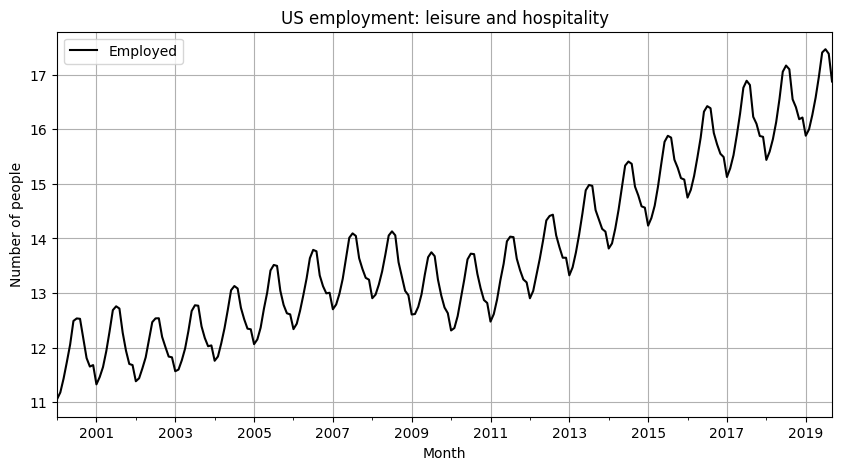

In [6]:
df.plot(
    kind='line',
    y='Employed',
    figsize=(10,5),
    ylabel='Number of people',
    title='US employment: leisure and hospitality',
    grid='=D',
    color="k"
);

##### 4.1.1. Differencing & Unit Roots

Para esse exemplo, utilizei uma diferenciação sazonal e uma diferenciação normal para deixar a série estacionária.

No livro é indentificado um modelo arima da seguinte forma utilizando o gráfico da diferenciação sazonal seguida da diferenciação de grau 1:

1. O Spike significativo no lag 2 do ACF indica um MA(2) não sazonal.
2. O Spike significativo no lag 12 do ACF indica um MA(1) sazonal.
3. SARIMA(0, 1, 2)(0, 1, 1, 12).

As duas diferenciações, nos componentes d e D indicam uma diferenciação normal e uma diferenciação sazonal e o m = 12 pois os dados são mensais.

Entretanto é possível derivar um outro modelo olhando o gráfico de PACF.

1. SARIMA(2, 1, 0)(0, 1, 1, 12), onde existe o componente p = 2 pois existe até o segundo ponto do PACF significativo, ambos os componentes d e D para as diferenciações e o MA sazonal igual a 1 pois existe ponto significativo para a sazonalidade no ACF lag 12, e m = 12 pois os dados são mensais.

/tmp/ipykernel_4463/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


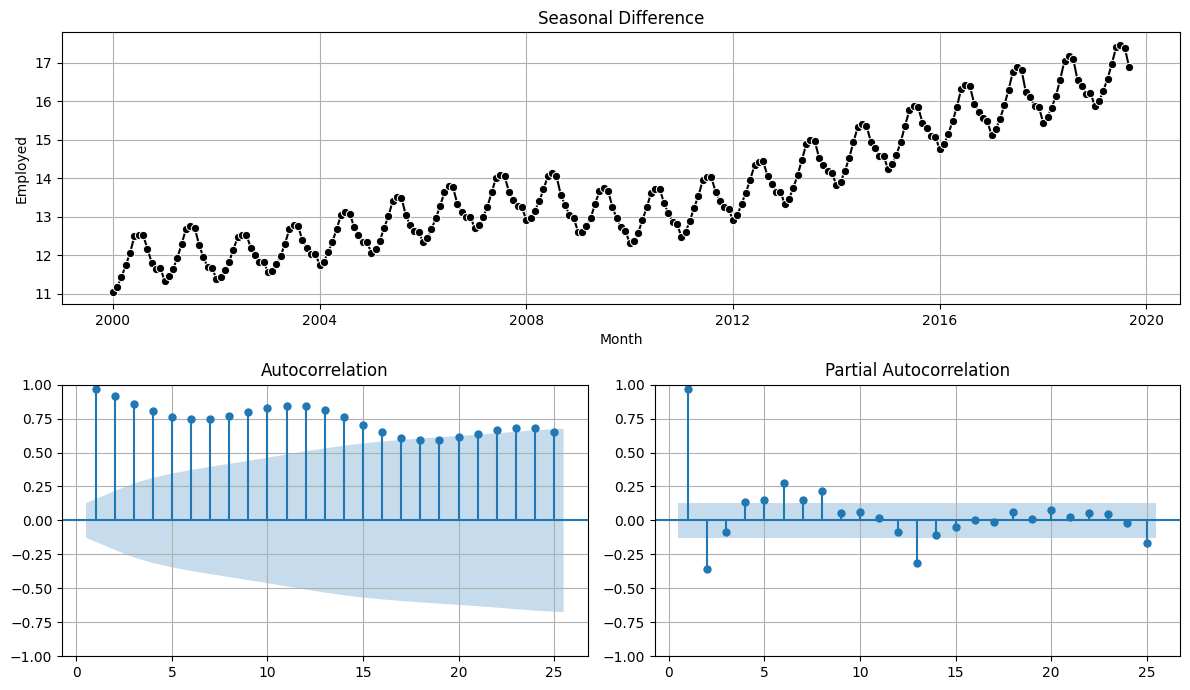

In [7]:
plot_ts_acf(df, x='Month', y='Employed')

/tmp/ipykernel_4463/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


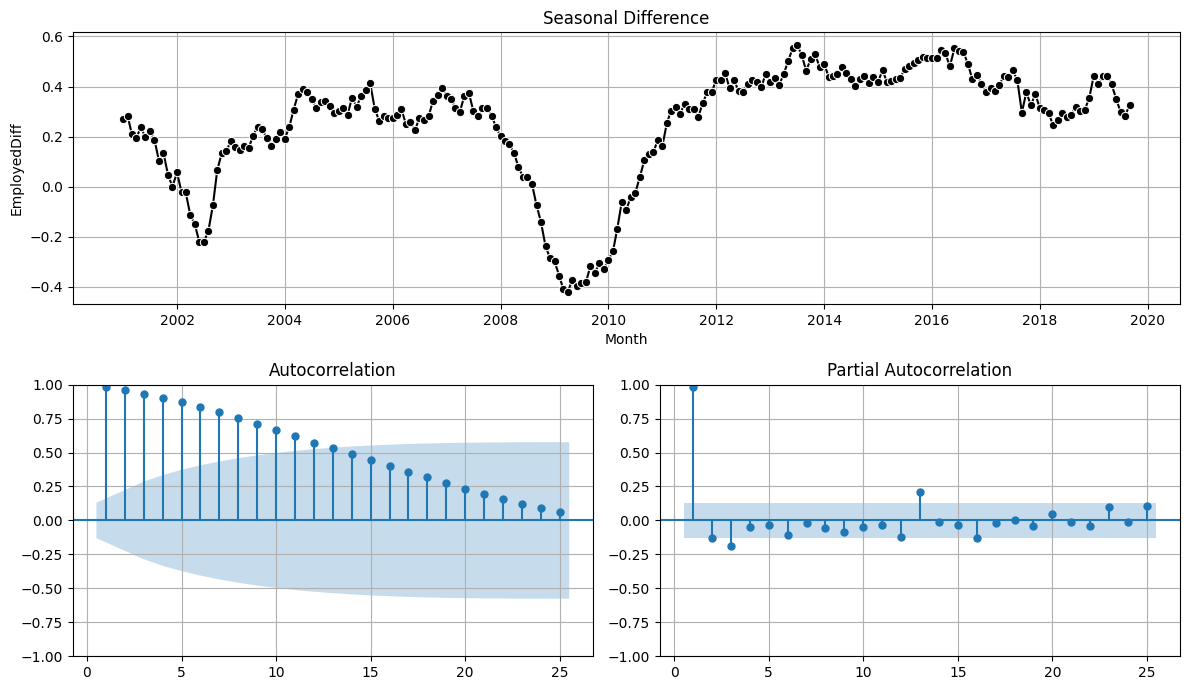

In [8]:
df['EmployedDiff'] = df['Employed'].diff(12)

plot_ts_acf(df, x='Month', y='EmployedDiff')

/tmp/ipykernel_4463/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


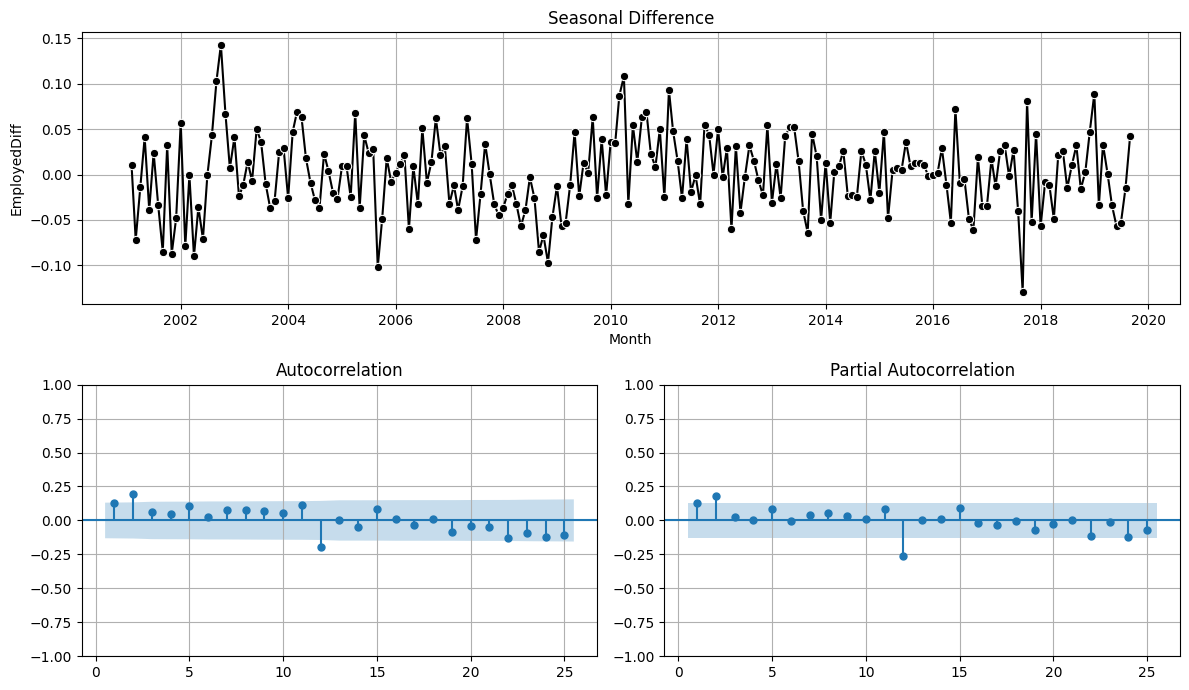

In [9]:
df['EmployedDiff'] = df['Employed'].diff(12).diff()

plot_ts_acf(df, x='Month', y='EmployedDiff')

In [10]:
# Ho: Stationary.
# Ha: Non Stationary.

kpss_test, p, lags, c_values = kpss(df['Employed']);

results = pd.DataFrame(
    {'Test Statistic': kpss_test,
     'P-Value': p,
     'Lags Used': lags} | c_values,
    index=[0]
)

display(results)

if p < .05:
    print(f'With Pvalue of: {p}, Reject Ho. (Serie is N-Stationary).')
else:
    print(f'With P-Value of: {p}, Accept Ho. (Serie is Stationary).')

/tmp/ipykernel_8461/2101288578.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test, p, lags, c_values = kpss(df['Employed']);


,Test Statistic,P-Value,Lags Used,10%,5%,2.5%,1%
0,2.269277,0.01,9,0.347,0.463,0.574,0.739


With Pvalue of: 0.01, Reject Ho. (Serie is N-Stationary).


In [11]:
# Ho: Non Stationary.
# Ha: Stationary.

adf_test, p, _, _, _, _ = adfuller(df['Employed'])

results = pd.DataFrame(
    {'Adf Test': adf_test,
     'P-Value': p},
    index=[0]
)

display(results)

if p < .05:
    print(f'With P-Value of: {p}, Reject Ho, (Serie is Stationary).')
else:
    print(f'With P-Value of: {p}, Accept Ho, (Serie is N-Stationary).')

,Adf Test,P-Value
0,0.189086,0.971643


With P-Value of: 0.9716427858327834, Accept Ho, (Serie is N-Stationary).


##### 4.1.2. Seasonal Arima 

In [12]:
arima012011 = pm.ARIMA(
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12)
).fit(df['Employed'])

arima210011 = pm.ARIMA(
    order=(2, 1, 0),
    seasonal_order=(0, 1, 1, 12)
).fit(df['Employed'])

auto = pm.ARIMA(
    order=(2, 1, 0),
    seasonal_order=(1, 1, 1, 12),
    trend='ct'
).fit(df['Employed'])

res = pd.DataFrame(
    [{'model': 'arima012011', 'aicc': arima012011.aicc(), 'aic': arima012011.aic(), 'bic': arima012011.bic()} | \
        arima012011.params().to_dict(), 

     {'model': 'arima210011', 'aicc': arima210011.aicc(), 'aic': arima210011.aic(), 'bic': arima210011.bic()} | \
        arima210011.params().to_dict(),
        
     {'model': 'auto', 'aicc': auto.aicc(), 'aic': auto.aic(), 'bic': auto.bic()} | \
        auto.params().to_dict()]
)

display(arima012011)
display(arima210011)
display(auto)

display(res)

ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))

ARIMA(order=(2, 1, 0), seasonal_order=(0, 1, 1, 12))

ARIMA(order=(2, 1, 0), seasonal_order=(1, 1, 1, 12), trend='ct')

,model,aicc,aic,bic,intercept,ma.L1,ma.L2,ma.S.L12,sigma2,ar.L1,ar.L2,drift,ar.S.L12
0,arima012011,-801.211387,-801.471127,-784.412897,0.000609,0.144295,0.19899,-0.457908,0.001544,NaN,NaN,NaN,NaN
1,arima210011,-803.142699,-803.402439,-786.344209,0.000361,NaN,NaN,-0.462058,0.001529,0.159221,0.193411,NaN,NaN
2,auto,-793.837681,-794.326764,-770.445242,0.000363,NaN,NaN,-0.273293,0.001711,0.108143,0.178188,6.865160e-07,-0.003371


In [13]:
df['Resid'] = auto.resid()

aux = df[(df['Resid'] < 2.0) & (df['Resid'] > -2.0)] # To See because have two bif resids

/tmp/ipykernel_8461/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


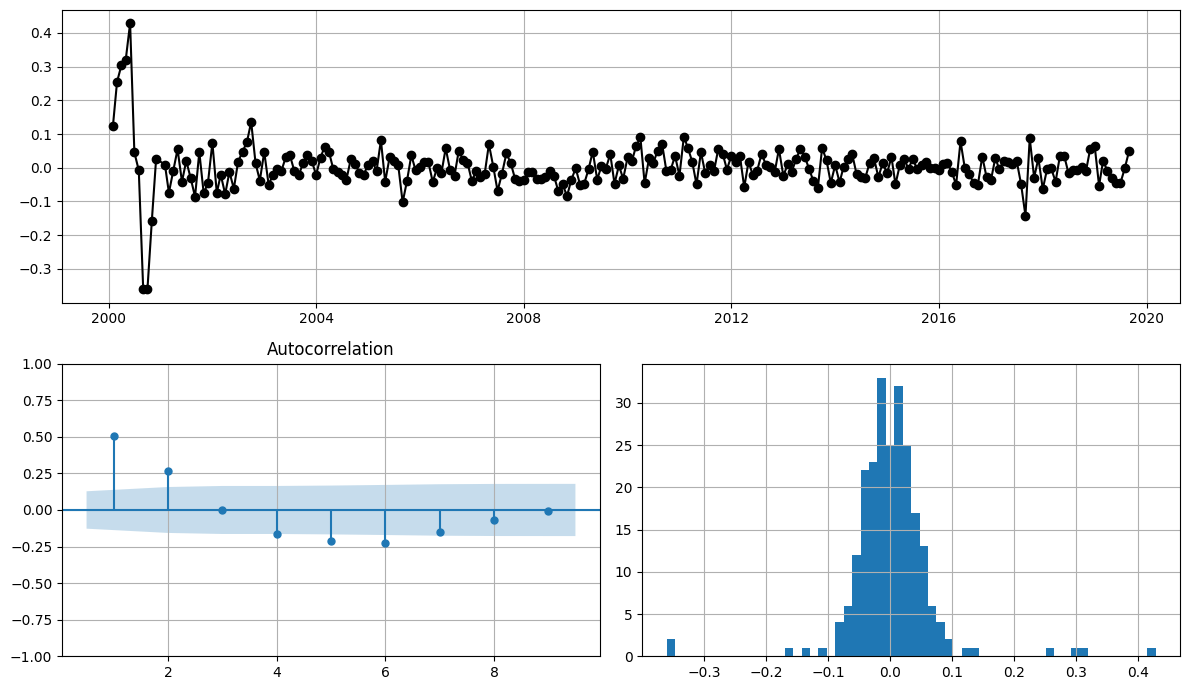

In [14]:
plot_ts_resid(aux, 'Month', y='Resid')

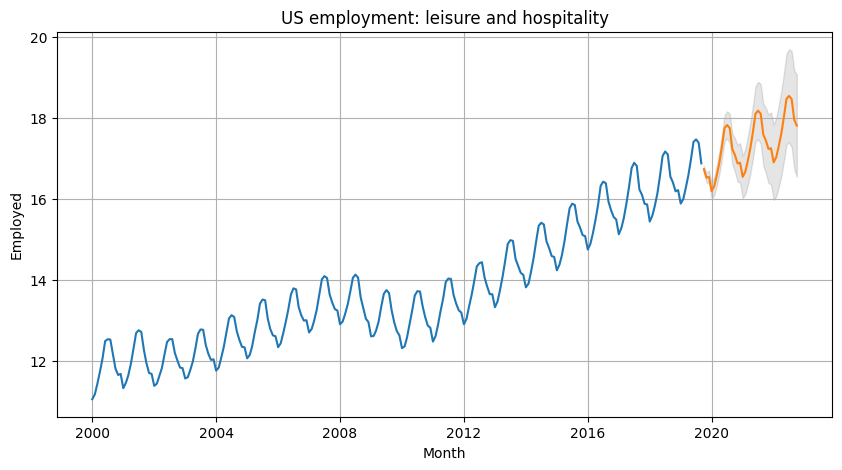

In [15]:
forecast, conf = auto.predict(37, return_conf_int=True)
conf = pd.DataFrame(conf, index=forecast.index)

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(df['Employed'])
sns.lineplot(forecast)
ax.fill_between(conf.index, conf[0], conf[1], color='k', alpha=0.1)
ax.grid(True)

ax.set_title('US employment: leisure and hospitality');

##### 4.1.3. Auto Arima

Entretanto rodando o Autoarima ele indentificou um modelo bem diferente dos analisados manualmente.

In [10]:
auto_arima = pm.auto_arima(
    df['Employed'],
    
    start_p=1, 
    start_q=1,
    test='adf', 
    max_p=10, 
    max_q=10,
    m=12,
    d=None, # Auto Arima Decide

    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=5,
    seasonal=True,
    stepwise=False,

    maxiter=50,
    trace=False,
    error_action='warn',
    suppress_warnings=True
);

In [19]:
auto_arima

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [21]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 411.455
Date:                                 Wed, 20 Dec 2023   AIC                           -812.909
Time:                                         21:24:02   BIC                           -795.851
Sample:                                     01-01-2000   HQIC                          -806.024
                                          - 09-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.071     12.693      0.000       0.764       1.043
ma.L1         -0.7898      0.096     -8.234      0.000      -0.978      -0.602
ma.S.L12      -0.4163      0.080     -5.220      0.000      -0.573      -0.260
ma.S.L24      -0.1846      0.079     -2.323      0.020      -0.340      -0.029
sigma2         0.0015      0.000     11.739      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.33
Prob(Q):                              0.93   Prob(JB):                         0.02
Heteroskedasticity (H):               0.82   Skew:                             0.01
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/tmp/ipykernel_8461/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


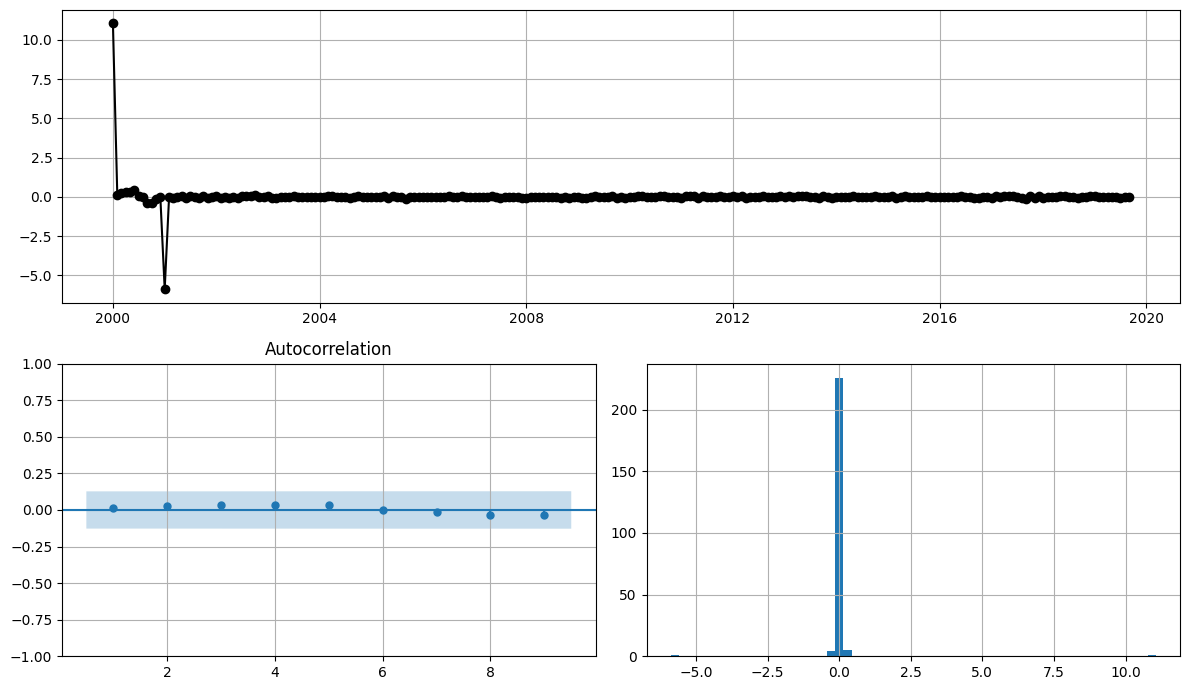

In [22]:
df['Resid'] = auto_arima.resid()

plot_ts_resid(df, 'Month', y='Resid')

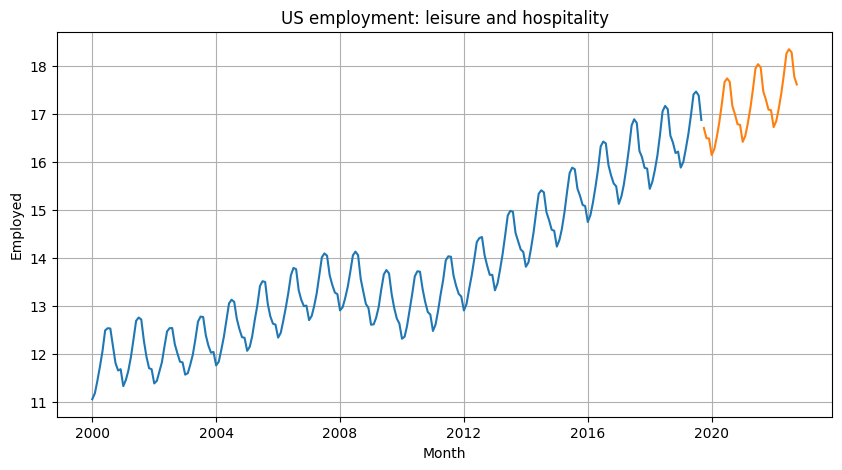

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(df['Employed'])
sns.lineplot(auto_arima.predict(37));
ax.grid(True)

ax.set_title('US employment: leisure and hospitality');

##### 4.1.4. Train and Test 

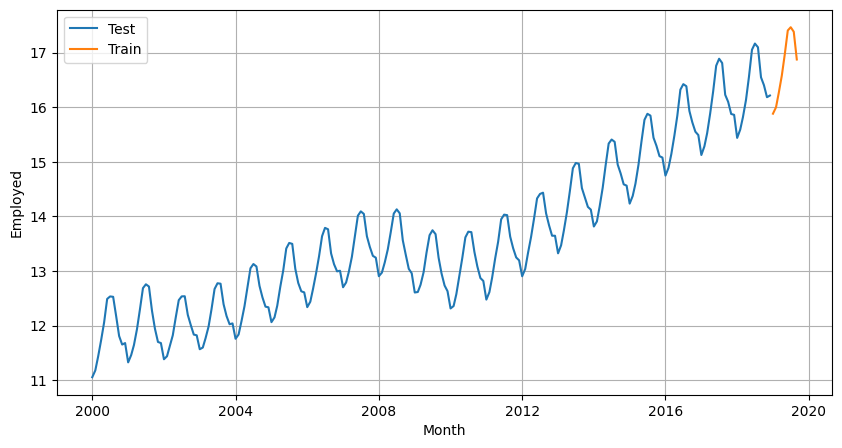

In [17]:
train = df[df.index < '2019']
test = df[df.index >= '2019']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(train['Employed'], label='Test')
sns.lineplot(test['Employed'], label='Train');
ax.grid(2)

In [22]:
auto_arima = pm.auto_arima(
    train['Employed'],
    start_p=1, 
    start_q=1,
    test='adf', 
    max_p=10, 
    max_q=10,
    m=12,
    d=None, # Auto Arima Decide
    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=5,
    seasonal=True,
    stepwise=True,
    maxiter=50,
    trace=False,
    error_action='warn',
    suppress_warnings=True
);

In [23]:
auto_arima

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
forecast, confs = auto_arima.predict(n_periods=len(test), return_conf_int=True)
test['Yhat'] = forecast

,R2,MAE
0,0.988677,51.081323


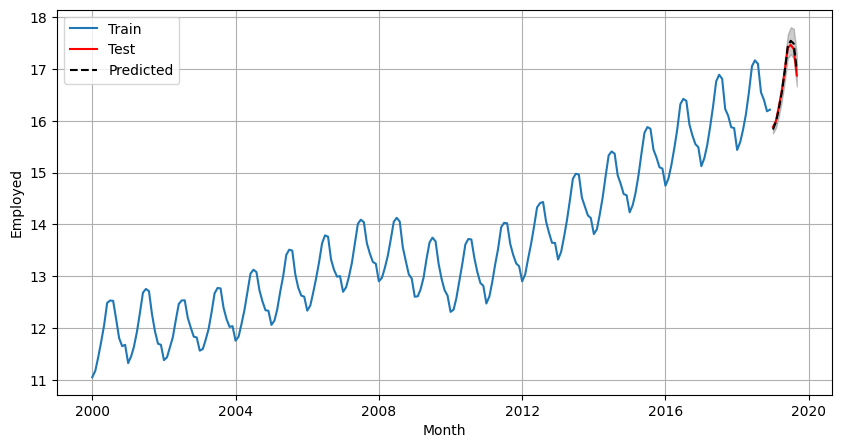

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(train['Employed'], label='Train')
sns.lineplot(test['Employed'], label='Test', color='r')
sns.lineplot(test['Yhat'], label='Predicted', linestyle='--', color='k')
ax.fill_between(forecast.index, confs[:,0], confs[:,1], alpha=.2, color='k');
ax.grid(2);

pd.DataFrame(
    {'R2': r2_score(test['Employed'] * 1_000, test['Yhat'] * 1_000), 
     'MAE': mean_absolute_error(test['Employed'] * 1_000, test['Yhat'] * 1_000)}, 
     index=[0]
)

#### 4.2. H02 Dataset

In [8]:
df = pd.read_csv('../data/PBS.csv', index_col=[0])

df = df[df['ATC2'] == 'H02']

df['Month'] = pd.to_datetime(df['Month'], format='%Y %b')

df = df[['Month', 'Cost']].groupby('Month').sum() / 1e6

df.index.freq = 'MS'

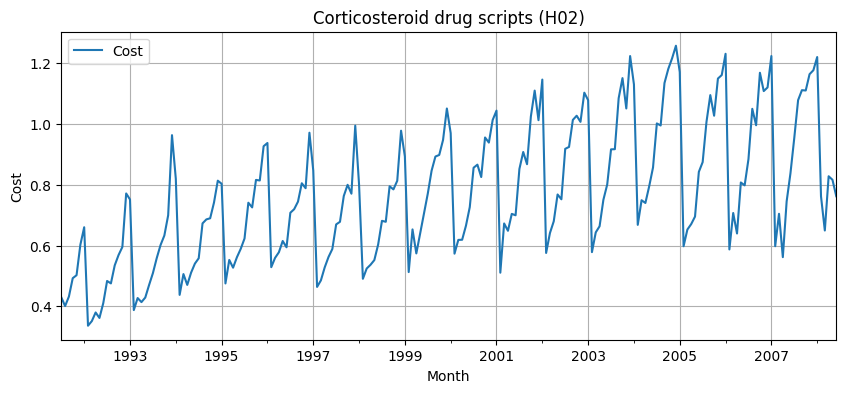

In [9]:
df.plot(
    kind='line',
    y='Cost',
    figsize=(10, 4),
    ylabel='Cost',
    title="Corticosteroid drug scripts (H02)",
    grid='=D'
);

##### 4.2.1. Differencing

Para esse modelo, no livro é aplicado um Log e a diferenciação sazonal.

Olhando os gráficos de ACF e PACF podemos escolher alguns modelos Sarimas apropriados, no livro foi selecionado o seguinte modelo:

SARIMA(3, 0, 0)(2, 1, 0, 12), O componente p é dois pois existem 3 pontos significantes no PACF, os demais são zero pois não é feito diferenciação e também não precisamos especificar nada de MA na parte não sazonal pois não mostrou nenhum padrão no ACF. Já para a parte sazonal é feito uma diferenciação para remover a sazonalidade, e um AR(2) sazonal pois existe dois picos nos lags 12 e 24.

In [10]:
df['CostLogDiff'] = np.log1p(df.Cost)
df['CostLogDiff'] = df['CostLogDiff'].diff(12)

/tmp/ipykernel_5074/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


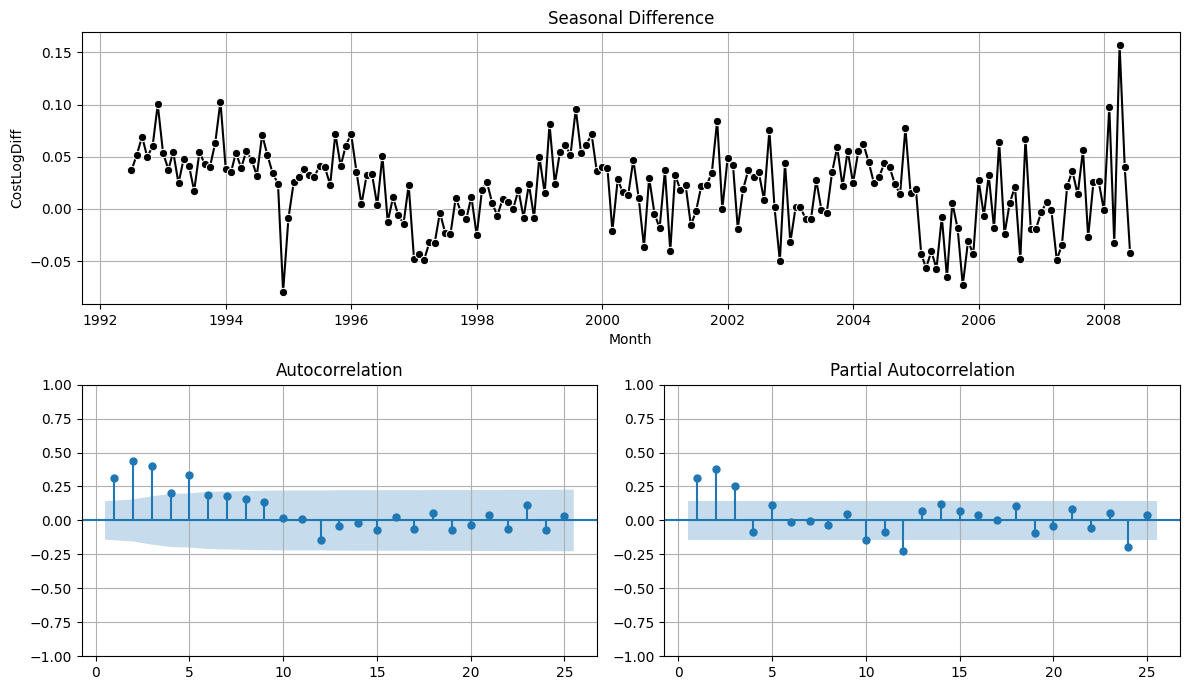

In [11]:
plot_ts_acf(df, x='Month', y='CostLogDiff')

##### 4.2.2. Seasonal Arima

In [12]:
model = pm.ARIMA(
    order=(3, 0, 1),
    seasonal_order=(2, 1, 0, 12),
    suppress_warnings=True
).fit(np.log1p(df['Cost']))

df['Resid'] = model.resid()

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 12)   Log Likelihood                 410.378
Date:                             Thu, 21 Dec 2023   AIC                           -804.757
Time:                                     16:52:30   BIC                           -778.697
Sample:                                 07-01-1991   HQIC                          -794.202
                                      - 06-01-2008                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0091      0.005      1.995      0.046       0.000       0.018
ar.L1         -0.2569      0.169     -1.520      0.128      -0.588       0.074
ar.L2          0.4547      0.070      6.520      0.000       0.318       0.591
ar.L3          0.5052      0.081      6.265      0.000       0.347       0.663
ma.L1          0.3961      0.188      2.105      0.035       0.027       0.765
ar.S.L12      -0.4051      0.072     -5.614      0.000      -0.547      -0.264
ar.S.L24      -0.3599      0.080     -4.516      0.000      -0.516      -0.204
sigma2         0.0008   7.04e-05     11.230      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.91   Prob(JB):                         0.05
Heteroskedasticity (H):               1.95   Skew:                            -0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/tmp/ipykernel_5074/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


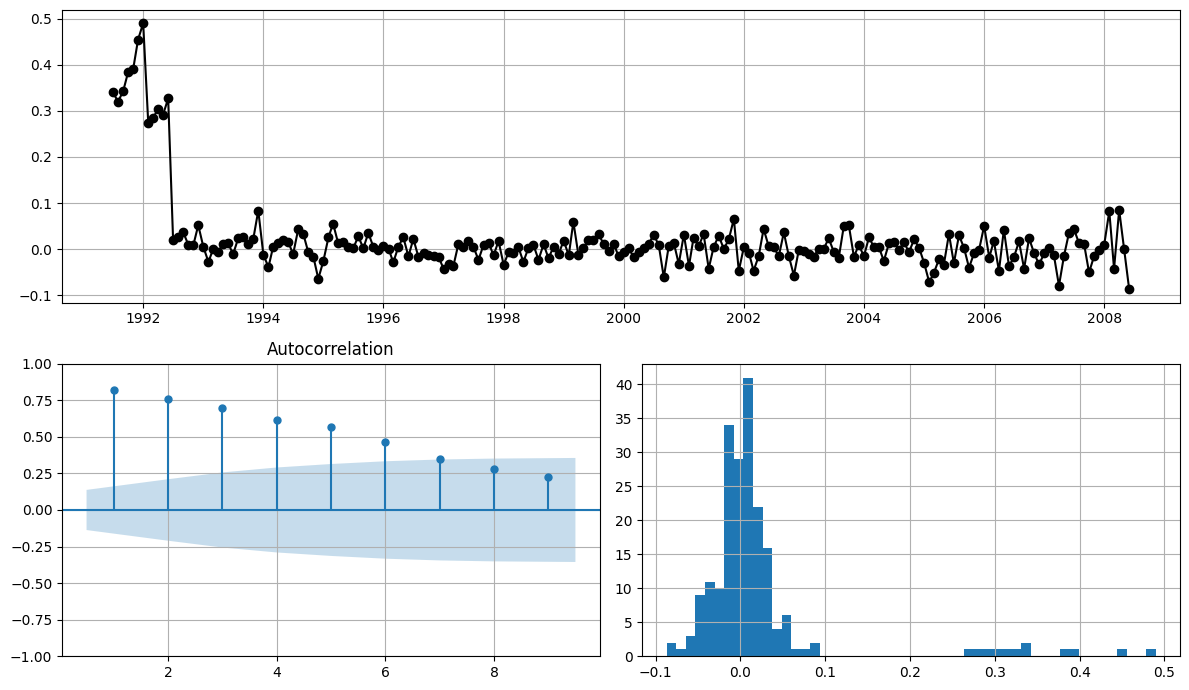

In [14]:
plot_ts_resid(df, x='Month', y='Resid')

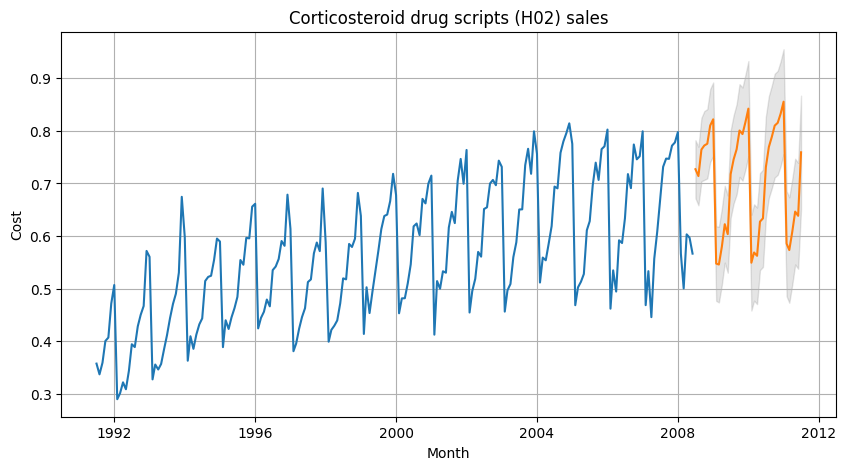

In [15]:
forecast, conf = model.predict(37, return_conf_int=True)
conf = pd.DataFrame(conf, index=forecast.index)

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(np.log1p(df['Cost']))
sns.lineplot(forecast)
ax.fill_between(conf.index, conf[0], conf[1], color='k', alpha=0.1)
ax.grid(True)

ax.set_title('Corticosteroid drug scripts (H02) sales');

##### 4.2.3. Train and Test

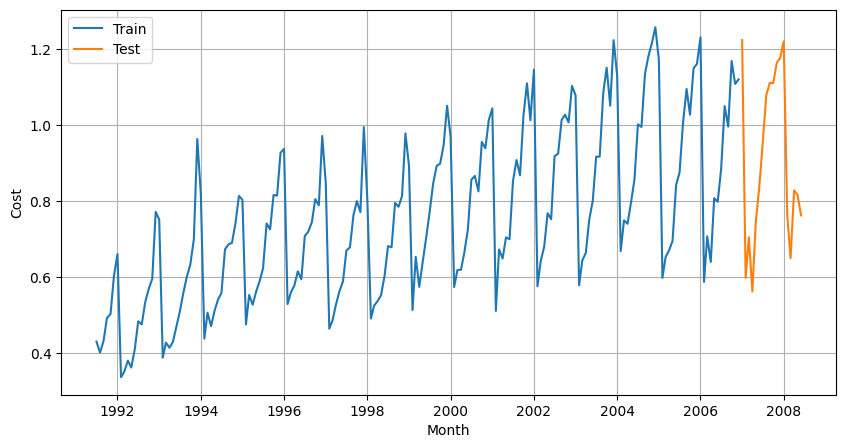

In [16]:
train = df[df.index < '2007']
test = df[df.index >= '2007']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(train['Cost'], label='Train')
sns.lineplot(test['Cost'], label='Test')
ax.grid(':)')

In [33]:
auto_arima = pm.auto_arima(
    np.log1p(train['Cost']),
    start_p=1, 
    start_q=1,
    test='adf', 
    max_p=10, 
    max_q=10,
    m=12,
    d=None,
    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=5,
    seasonal=True,
    stepwise=True,
    maxiter=50,
    trace=False,
    error_action='warn',
    suppress_warnings=True
);

In [34]:
auto_arima

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 4, 12),
      suppress_warnings=True, with_intercept=False)

In [37]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                             y   No. Observations:                  186
Model:             SARIMAX(2, 1, 0)x(0, 1, [1, 2, 3, 4], 12)   Log Likelihood                 384.824
Date:                                       Thu, 21 Dec 2023   AIC                           -755.649
Time:                                               17:04:58   BIC                           -733.575
Sample:                                           07-01-1991   HQIC                          -746.694
                                                - 12-01-2006                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7954      0.063    -12.553      0.000      -0.920      -0.671
ar.L2         -0.3529      0.071     -4.957      0.000      -0.492      -0.213
ma.S.L12      -0.5024      0.079     -6.337      0.000      -0.658      -0.347
ma.S.L24      -0.3058      0.111     -2.744      0.006      -0.524      -0.087
ma.S.L36       0.1926      0.109      1.761      0.078      -0.022       0.407
ma.S.L48       0.1472      0.092      1.602      0.109      -0.033       0.327
sigma2         0.0006   6.87e-05      9.411      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.67   Prob(JB):                         0.55
Heteroskedasticity (H):               1.27   Skew:                            -0.12
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
dfr = auto_arima.resid().reset_index()

dfr.columns = ["Month", "Resid"]

/tmp/ipykernel_5074/1441311680.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


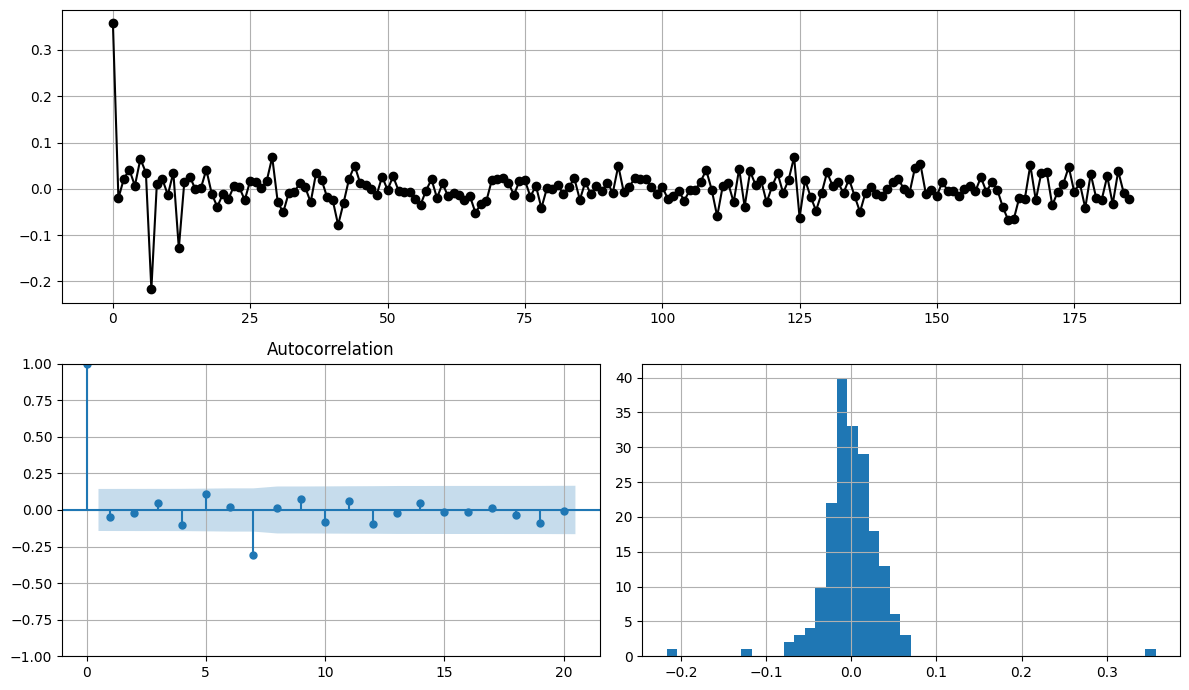

In [41]:
plot_ts_resid(dfr, x='Month', y='Resid', n_lags=20)

In [42]:
forecast, confs = auto_arima.predict(n_periods=len(test), return_conf_int=True)
test['Yhat'] = forecast

/tmp/ipykernel_5074/2361893071.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Yhat'] = forecast


,R2,MAE
0,0.906698,0.048796


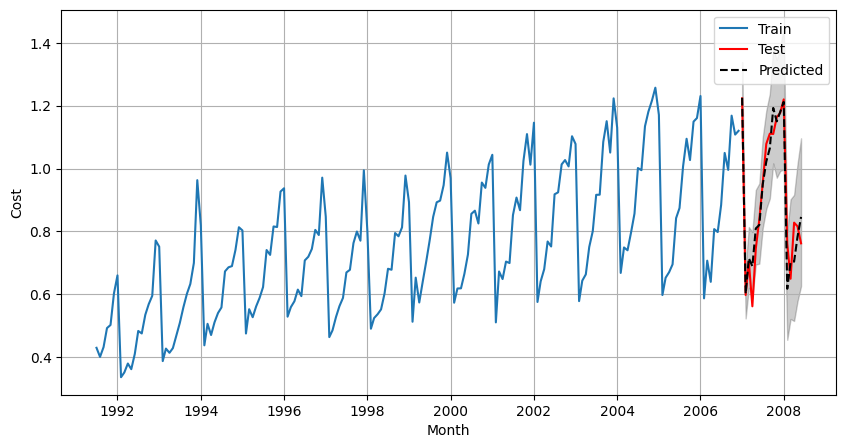

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(train['Cost'], label='Train')
sns.lineplot(test['Cost'], label='Test', color='r')
sns.lineplot(np.expm1(test['Yhat']), label='Predicted', linestyle='--', color='k')
ax.fill_between(forecast.index, np.expm1(confs[:,0]), np.expm1(confs[:,1]), alpha=.2, color='k');
ax.grid(2);

pd.DataFrame(
    {'R2': r2_score(test['Cost'], np.expm1(test['Yhat'])), 
     'MAE': mean_absolute_error(test['Cost'], np.expm1(test['Yhat']))}, 
     index=[0]
)

#### 4.3. Turkey GDP

In [38]:
df = pd.read_csv('../data/global_economy.csv', index_col=[0])

df = df[df.Code == 'TUR'].reset_index(drop=True)

df.GDP = df.GDP / 1e10

df['Year'] = pd.to_datetime(df['Year'], format='%Y')

df = df.set_index('Year')

df.index.freq = 'AS-JAN'

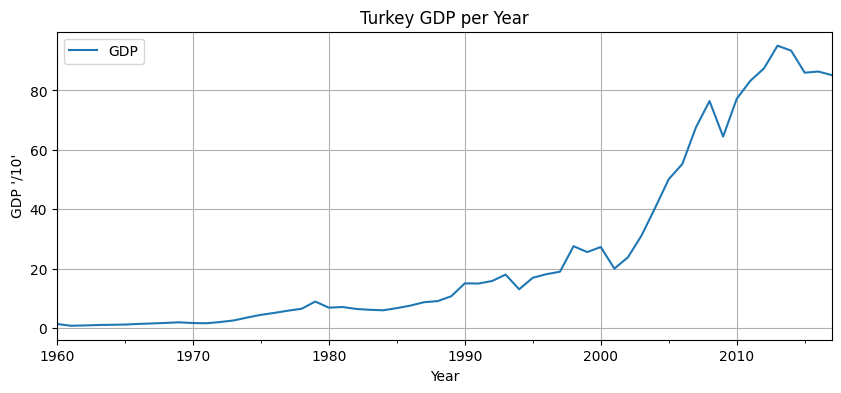

In [39]:
df.plot(
    kind='line',
    y='GDP',
    grid=True,
    title='Turkey GDP per Year',
    ylabel="GDP '/10'",
    figsize=(10,4)
);

##### 4.3.1. Differencing

/tmp/ipykernel_12027/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


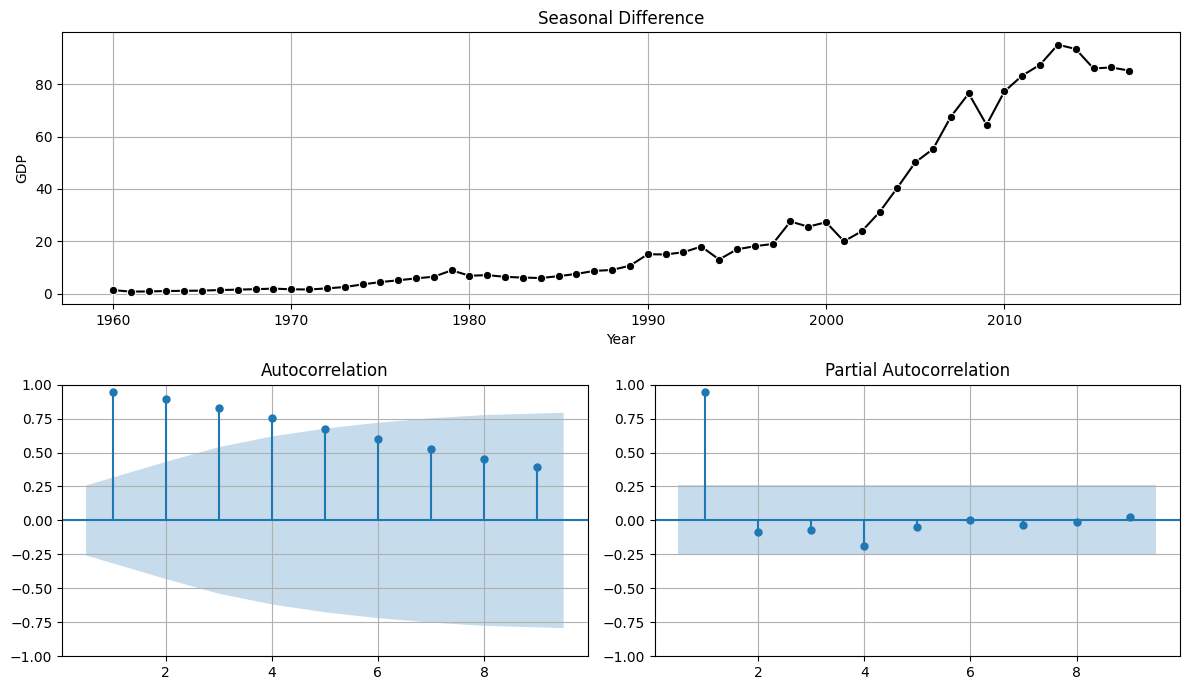

In [40]:
plot_ts_acf(df, x='Year', y='GDP', n_lags=range(1,10))

/tmp/ipykernel_12027/1441311680.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)


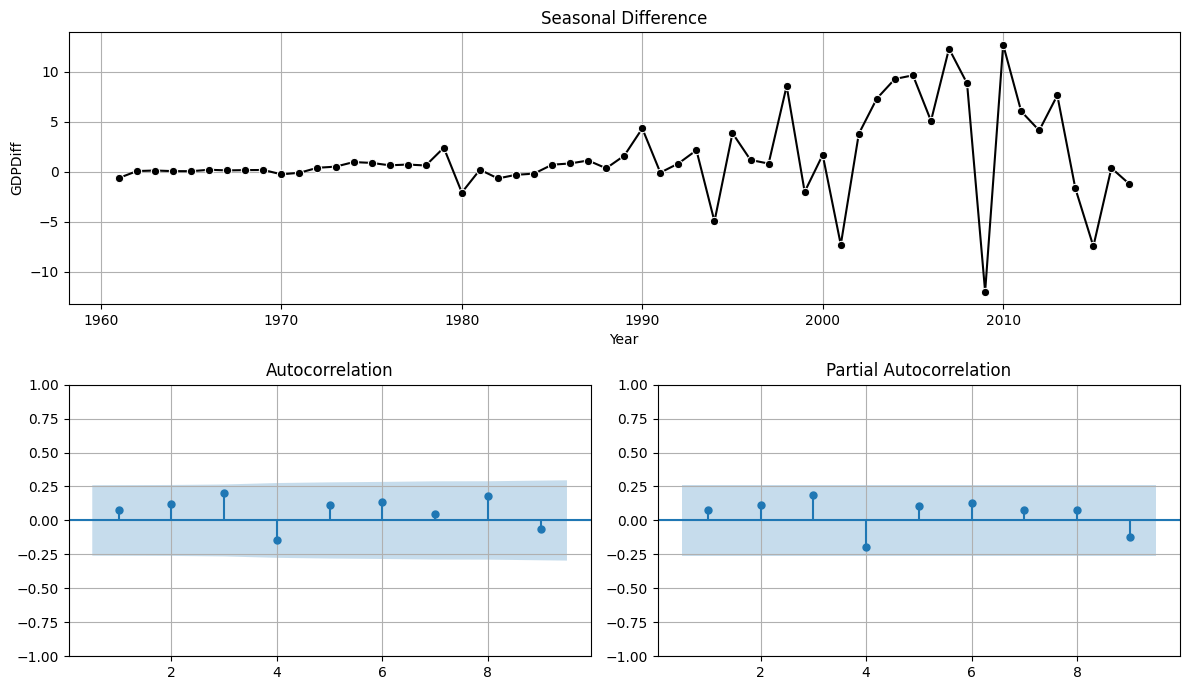

In [41]:
df['GDPDiff'] = df['GDP'].diff(1)

plot_ts_acf(df, x='Year', y='GDPDiff', n_lags=range(1,10))

##### 4.3.2. Auto Arima

In [42]:
auto_arima = pm.auto_arima(
    np.log1p(df['GDP']),
    start_p=1, 
    start_q=1,
    test='adf', 
    max_p=10, 
    max_q=10,
    m=12,
    d=None,
    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=5,
    seasonal=True,
    stepwise=True,
    maxiter=50,
    trace=False,
    error_action='warn',
    suppress_warnings=True
);

auto_arima

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima = pm.ARIMA(
    order=(1, 0, 2),             # If Diff, "trend up".
    seasonal_order=(0, 0, 0, 12) 
).fit(
    np.log1p(df['GDP'])
)

auto_arima

ARIMA(order=(1, 0, 2), seasonal_order=(0, 0, 0, 12))

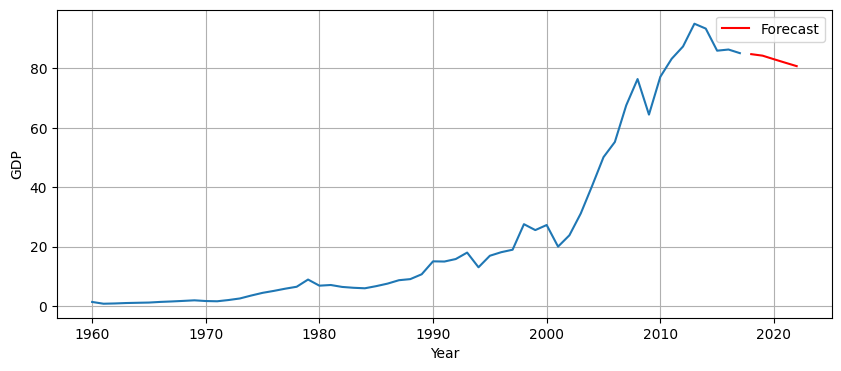

In [44]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(df['GDP'])
sns.lineplot(np.expm1(auto_arima.predict(5)), label='Forecast', color='r')
ax.grid('.')